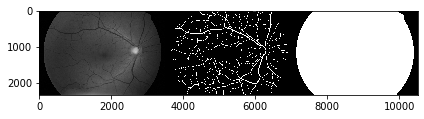

In [1]:
import skimage.io
import skimage.color
import os
import numpy as np
from skimage.util import img_as_float, img_as_uint,img_as_ubyte
from skimage.exposure import rescale_intensity
import imutils
import cv2
import time
import statistics
from scipy.stats import moment
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from skimage import data

def loadImageNr(id,show=False):
    
    img_list=os.listdir("./all/images")
    if(id>=len(img_list)):
        print("> bad img num, max: "+str(len(img_list)-1))
        return
    exp_list=os.listdir("./all/manual1")
    fov_list=os.listdir("./all/mask")
    img=img_as_float(skimage.io.imread("./all/images/"+str(img_list[id])))
    exp=img_as_float(skimage.io.imread("./all/manual1/"+str(exp_list[id])))
    fov=skimage.io.imread("./all/mask/"+str(fov_list[id]),as_gray=True)
    img=img[:, :, 1]
    if(show): 
        skimage.io.imshow(np.hstack([img,exp,fov]))
        skimage.io.show()
    return (img,exp,fov)

(img,exp,fov)=loadImageNr(44,show=True)
resize=False
target_width=200
if(resize):
    img=imutils.resize(img,width=target_width)
    exp=imutils.resize(img,width=target_width)
    fov=imutils.resize(img,width=target_width)

In [ ]:
def sliding_window(image,fov, stepSize, windowSize):
    dim=image.shape
    dim_x=dim[1]
    dim_y=dim[0]
    for y in range(0, dim_y, stepSize):
        if y + windowSize >= dim_y: # bottom border - discard
            continue 
            
        for x in range(0, dim_x, stepSize):
            if x + windowSize >= dim_x: # right border - discard
                continue 
            if fov[y,x] and fov[y+windowSize,x+windowSize] and fov[y,x+windowSize] and fov[y+windowSize,x]:
                #all corners inside FOV
                yield (x, y, image[y:y + windowSize, x:x + windowSize])
                
windowSize=5
stepSize=5
visualize=True
#learning
print("preparing data...")
correct_answers=[]
inputs=[]
for i in sliding_window(img, fov, stepSize, windowSize):
    pass
print("generated")
for (x, y, window) in sliding_window(img, fov, stepSize, windowSize):
    correct_answer = exp[y+windowSize//2,x+windowSize//2]>0.5
    flat_window=window.flatten()
    pvar=statistics.pvariance(flat_window)
    mom2=moment(flat_window,2)
    correct_answers.append(correct_answer)
    inputs.append([pvar,mom2])
    
    if(visualize):
        whole_img = img.copy()
        cv2.rectangle(whole_img, (x, y), (x + windowSize, y + windowSize), (255, 255, 0), 2)
        cv2.imshow("Whole_img", imutils.resize(whole_img,width=900))

        window[2,2]=correct_answer
        cv2.imshow("Window", imutils.resize(window,width=300))
        print(pvar,correct_answer, mom2)
        cv2.waitKey(1000)
#learning 
print("learning (fitting)...")
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(inputs, correct_answers)

In [ ]:
#predicting
print("preparing data to predict...")
predicted_image=np.zeros(fov.shape)
inputs_to_predict=[]
cordinates=[]

#def process_window(input):
#    x, y, window=input
#    flat_window=window.flatten()
#    pvar=statistics.pvariance(flat_window)
#    mom2=moment(flat_window,2)
#    inputs_to_predict.append([[pvar,mom2]])
#    cordinates.append((x,y))
#map(process_window,sliding_window(img, fov, 1, windowSize))


#for (x, y, window) in sliding_window(img, fov, 1, windowSize):
#    flat_window=window.flatten()
#    pvar=statistics.pvariance(flat_window)
#    mom2=moment(flat_window,2)
#    inputs_to_predict.append([[pvar,mom2]])
#    cordinates.append((x,y))

def some_func(roi):
    '''
    simple function to return the mean of the region
    of interest
    '''
    return np.mean(roi)

img_shape = img.shape

size = 5 # window size i.e. here is 3x3 window

shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
strides = 2 * img.strides
patches = np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)
patches = patches.reshape(-1, size, size)

output_img = np.array([some_func(roi) for roi in patches])
output_img.reshape(img_size)
 
print("predicting...")    
answers=clf.predict(inputs_to_predict)  
ans_cord=zip(answers,cordinates)
print("writing results...")
def process_answer(input):
    answer,cordinates=input
    x,y=cordinates
    predicted_image[y+windowSize//2,x+windowSize//2]=answer
map(process_answer,ans_cord)
print("done...")
skimage.io.imshow(predicted_image,cmap='gray')
cv2.imshow("XD",imutils.resize(predicted_image,width=900))

In [ ]:
import imblearn
print(imblearn.__version__)
cv2.imwrite("cv.png",cv2img)
#norm_img = np.zeros((800,800))
#final_img = cv2.normalize(cv2img,  norm_img, 0, 255, cv2.NORM_MINMAX)
#cv2img = ~cv2img
#cv2.equalizeHist(cv2img)
def process_img(img):
    img_res=imutils.resize(img,width=width)
    img_res=img_as_ubyte(img_res)
    return img_res

def show_imgs(arr):
    res=map(process_img,arr)
    return list(res)
#cv2.imshow("test",im)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
from ipywidgets import interact
import spiepy
@interact(x=(0, 100))
def double_number(x):
    width=400
    im=img_as_ubyte(imutils.resize(img,width=width))
    im=~im
    #pmin, pmax = np.percentile(im, (1,x))
    #print(p2,p98)
    #im_res=rescale_intensity(im, in_range=(pmin,pmax)) 
    im_res=im.copy()
    #im_res=cv2.equalizeHist(im_res)
    #im_res, _ = spiepy.flatten_xy(im)

    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl1 = clahe.apply(im)
    im_res=cl1
    cv2.imwrite("clahe.png",im_res)
    
    skimage.io.imshow(np.hstack((im,im_res)))
    skimage.io.show()


In [ ]:
cv2.destroyAllWindows()

In [ ]:
from multiprocessing import Pool
def some_func(roi):
    print(1,end='')
    return np.var(roi)

img2=img.copy()
img_size = img2.shape

size = 5 # window size i.e. here is 3x3 window

shape = (img2.shape[0] - size + 1, img2.shape[1] - size + 1, size, size)
strides = 2 * img2.strides
patches = np.lib.stride_tricks.as_strided(img2, shape=shape, strides=strides)
patches = patches.reshape(-1, size, size)
print(len(patches))
print(patches[0])
output_img=1
#output_img = np.array([some_func(roi) for roi in patches])
with Pool(processes=8) as pool:
    output_gen=pool.map(some_func,patches,1)
    print(output_gen)

    output_img=np.array([i for i in output_gen])
    print("XD")
xxx=output_img.reshape(shape[0:2])
skimage.io.imshow(xxx,cmap='gray')





8162000
[[0.00784314 0.00392157 0.00392157 0.         0.        ]
 [0.00784314 0.00392157 0.00392157 0.         0.        ]
 [0.00392157 0.00392157 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.         0.         0.00392157]]
